In [52]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
import joblib
from sklearn.metrics import brier_score_loss
import json
from rapidfuzz import process

In [20]:
pd.set_option('display.max_columns', None)
matches = pd.read_csv("data/prepared_data.csv")
matches = matches[matches['round'] > 3]
matches['over_2.5'] = matches['home_goals'] + matches['away_goals'] > 2.5
matches.head(2)

,season,date,time,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_possession,away_possession,home_lineup,away_lineup,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,league,Unnamed: 0.1,Unnamed

#### Przygotowanie ramki danych ze statystykami z ostatnich meczów

In [21]:
rolling_stats = matches[[col for col in matches.columns if 'last5' in col or 'over_2.5' in col or 'matches_since' in col or 'overall' in col or 'tiredness' in col or 'h2h' in col]]

In [22]:
rolling_stats.groupby(['over_2.5']).mean()

,home_last5_matches_played,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_possession,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_tackles,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_completed_medium,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenges,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_tackles_interceptions,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_matches_played,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_possession,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_xg,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_kicks,awa

In [25]:
rolling_stats = rolling_stats.drop(columns = ["home_last5_possession", "away_last5_possession"])
rolling_stats = rolling_stats[~rolling_stats.isna().any(axis=1)]

#### Normalizacja danych

In [27]:
X = rolling_stats.drop(columns=["over_2.5"])
y = rolling_stats["over_2.5"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
log_reg.fit(X_train_scaled, y_train)
model = SelectFromModel(log_reg, prefit=True)
selected_features = X.columns[model.get_support()].tolist()
print("Selected Features based on Logistic Regression:")
print(selected_features)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

Selected Features based on Logistic Regression:
['home_last5_defeats', 'home_last5_goals_conceded', 'home_last5_minutes', 'home_last5_goals', 'home_last5_assists', 'home_last5_pens_made', 'home_last5_pens_att', 'home_last5_shots', 'home_last5_shots_on_target', 'home_last5_cards_yellow', 'home_last5_cards_red', 'home_last5_interceptions', 'home_last5_blocks', 'home_last5_xg', 'home_last5_xg_assist', 'home_last5_sca', 'home_last5_gca', 'home_last5_passes_pct', 'home_last5_progressive_passes', 'home_last5_carries', 'home_last5_progressive_carries', 'home_last5_take_ons', 'home_last5_passes_total_distance', 'home_last5_passes_progressive_distance', 'home_last5_passes_short', 'home_last5_passes_pct_short', 'home_last5_passes_completed_medium', 'home_last5_passes_medium', 'home_last5_passes_pct_medium', 'home_last5_passes_completed_long', 'home_last5_passes_long', 'home_last5_pass_xa', 'home_last5_assisted_shots', 'home_last5_passes_into_final_third', 'home_last5_passes_into_penalty_area', '

#### Zapis używanych zmiennych oraz skalowania do plików

In [ ]:
# with open("goals_features_v1.json", "w", encoding="utf-8") as f:
#     json.dump(selected_features, f)
# joblib.dump(scaler, "goals_scaler_v1.pkl")

['goals_scaler_v1.pkl']

In [28]:
train_df =  pd.DataFrame(X_train_selected, columns=selected_features)
test_df =  pd.DataFrame(X_test_selected, columns=selected_features)
train_df["over_2.5"] = y_train.reset_index(drop=True)
test_df["over_2.5"] = y_test.reset_index(drop=True)

#### Wczytywanie danych do torcha

In [29]:
class FootballDataset(Dataset):
    def __init__(self, agg_stats):
        self.agg_stats = agg_stats.drop('over_2.5', axis=1).values  # Convert to numpy array
        self.labels = agg_stats['over_2.5'].values  # Convert to numpy array
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return features and labels as tensors
        features = torch.tensor(self.agg_stats[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, labels

In [30]:
# train_df, test_df = train_test_split(rolling_stats, test_size=0.3, random_state=42)
dataset = FootballDataset(train_df)
test_dataset = FootballDataset(test_df)
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

#### Prosta sieć neuronowa z 3 warstwami

In [86]:
class FootballMatchPredictor(nn.Module):
    def __init__(self, input_agg_stats_size, hidden_size=64):
        super(FootballMatchPredictor, self).__init__()
        
        self.agg_stats_fc = nn.Sequential(
            nn.Linear(input_agg_stats_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        
        combined_input_size = hidden_size // 2
        self.fc_combined = nn.Sequential(
            nn.Linear(combined_input_size, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, 2),  # Output: 2 probabilities (over/under)
        )

    def forward(self, agg_stats):

        agg_stats_out = self.agg_stats_fc(agg_stats)

        output = self.fc_combined(agg_stats_out)
        
        return F.softmax(output, dim=1)

#### Narazie najlepsza loss function - która gwarantuje, że prawdopodbieństwo remisów nie jest zbyt małe jak w przypadku innych loss functions

In [87]:
def weighted_cross_entropy_loss(predictions, targets):
    predictions_probs = F.softmax(predictions, dim=1)
    one_hot_targets = F.one_hot(targets, num_classes=2).float()

    smoothed_targets = one_hot_targets.clone()
    for i, target in enumerate(targets):
        if target == 0:
            smoothed_targets[i] = torch.tensor([0.73, 0.27])
        elif target == 1:
            smoothed_targets[i] = torch.tensor([0.27, 0.73])
    

    loss_per_class = -smoothed_targets * torch.log(predictions_probs)

    return loss_per_class.sum(dim=1).mean()


In [93]:
model = FootballMatchPredictor(235)

criterion = weighted_cross_entropy_loss
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

num_epochs = 5 
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model
# torch.save(model, 'goals_predictor_new.pth')

Epoch 1/5:   0%|          | 0/2012 [00:00<?, ?it/s]C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\4282008362.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels = torch.tensor(self.labels[idx], dtype=torch.long)
Epoch 1/5: 100%|██████████| 2012/2012 [00:04<00:00, 460.15it/s]


Epoch [1/5], Loss: 0.6935


Epoch 2/5: 100%|██████████| 2012/2012 [00:04<00:00, 442.49it/s]


Epoch [2/5], Loss: 0.6907


Epoch 3/5: 100%|██████████| 2012/2012 [00:04<00:00, 485.56it/s]


Epoch [3/5], Loss: 0.6899


Epoch 4/5: 100%|██████████| 2012/2012 [00:04<00:00, 427.16it/s]


Epoch [4/5], Loss: 0.6891


Epoch 5/5: 100%|██████████| 2012/2012 [00:04<00:00, 422.77it/s]

Epoch [5/5], Loss: 0.6884


In [108]:
model.eval()


with torch.no_grad():
    predictions = []
    probabilities=[]
    actuals = []

    for inputs, targets in test_dataloader:
        outputs = model(inputs)  # Shape will be [batch_size, 3]
        
        _, predicted_classes = torch.max(outputs, dim=1)
        
        probabilities.extend(outputs)
        predictions.extend(predicted_classes.cpu().numpy())
        actuals.extend(targets.numpy())


print("Predictions:", probabilities)
print("Predictions:", predictions)
print("Actuals:    ", actuals)

accuracy = (np.array(predictions) == np.array(actuals)).mean()
print(f'Accuracy: {accuracy:.4f}')
probabilities = torch.stack(probabilities).numpy()

C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\4282008362.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels = torch.tensor(self.labels[idx], dtype=torch.long)


Predictions: [tensor([0.5475, 0.4525]), tensor([0.4788, 0.5212]), tensor([0.5083, 0.4917]), tensor([0.5013, 0.4987]), tensor([0.5088, 0.4912]), tensor([0.4992, 0.5008]), tensor([0.5075, 0.4925]), tensor([0.4931, 0.5069]), tensor([0.5197, 0.4803]), tensor([0.5362, 0.4638]), tensor([0.5684, 0.4316]), tensor([0.3991, 0.6009]), tensor([0.5325, 0.4675]), tensor([0.4402, 0.5598]), tensor([0.4464, 0.5536]), tensor([0.5755, 0.4245]), tensor([0.4938, 0.5062]), tensor([0.5785, 0.4215]), tensor([0.2664, 0.7336]), tensor([0.5235, 0.4765]), tensor([0.3302, 0.6698]), tensor([0.6285, 0.3715]), tensor([0.4714, 0.5286]), tensor([0.4940, 0.5060]), tensor([0.6110, 0.3890]), tensor([0.4668, 0.5332]), tensor([0.2720, 0.7280]), tensor([0.4518, 0.5482]), tensor([0.5383, 0.4617]), tensor([0.5364, 0.4636]), tensor([0.4224, 0.5776]), tensor([0.4140, 0.5860]), tensor([0.3790, 0.6210]), tensor([0.4659, 0.5341]), tensor([0.4760, 0.5240]), tensor([0.4017, 0.5983]), tensor([0.5533, 0.4467]), tensor([0.5698, 0.4302])

In [109]:
df = pd.DataFrame({
    'over': probabilities[:, 1],
    'under': probabilities[:, 0],
    'actual': actuals
})

bins = np.linspace(0, 1, 11)
df['bin_over'] = pd.cut(df['over'], bins=bins, labels=bins[:-1])
df['bin_under'] = pd.cut(df['under'], bins=bins, labels=bins[:-1])
calibration_over = df.groupby('bin_over', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['over'].mean(),
        'observed_freq': (x['actual'] == 1).mean(),
        'count': x['over'].count(),
        'difference' : - x['over'].mean() + (x['actual'] == 1).mean()
    })
).reset_index()
calibration_under = df.groupby('bin_under', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['under'].mean(),
        'observed_freq': (x['actual'] == 0).mean(),
        'count': x['under'].count(),
        'difference': - x['under'].mean() + (x['actual'] == 0).mean()
    })
).reset_index()

def mask_low_count(df, bin_col):
    for col in df.columns:
        if col != bin_col and col != 'count':
            df.loc[df['count'] < 16, col] = None
    return df

calibration_over["metric"] = abs(calibration_over["difference"]) * abs(calibration_over["difference"]) * calibration_over["count"] / len(df)
calibration_under["metric"] = abs(calibration_under["difference"]) * abs(calibration_under["difference"]) * calibration_under["count"] / len(df)

calibration_over = mask_low_count(calibration_over, 'bin_over')
calibration_under = mask_low_count(calibration_under, 'bin_under')

print("nasza metryka: " + str(calibration_over["metric"].sum() + calibration_under["metric"].sum()))
calibration_under

nasza metryka: 0.0005835882938331079


C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\981975700.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_over = df.groupby('bin_over', observed=False, dropna=False).apply(
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\981975700.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_under = df.groupby('bin_under', observed=False, dropna=False).apply(


,bin_under,avg_pred_prob,observed_freq,count,difference,metric
0,0.0,NaN,NaN,0.0,NaN,NaN
1,0.1,NaN,NaN,5.0,NaN,NaN
2,0.2,0.268843,0.247059,85.0,-0.021784,0.000012
3,0.3,0.360466,0.350734,613.0,-0.009732,0.000017
4,0.4,0.452710,0.467384,1395.0,0.014673,0.000087
5,0.5,0.546120,0.534746,1180.0,-0.011375,0.000044
6,0.6,0.615402,0.563953,172.0,-0.051448,0.000132
7,0.7,NaN,NaN,0.0,NaN,NaN
8,0.8,NaN,NaN,0.0,NaN,NaN
9,0.9,NaN,NaN,0.0,NaN,NaN


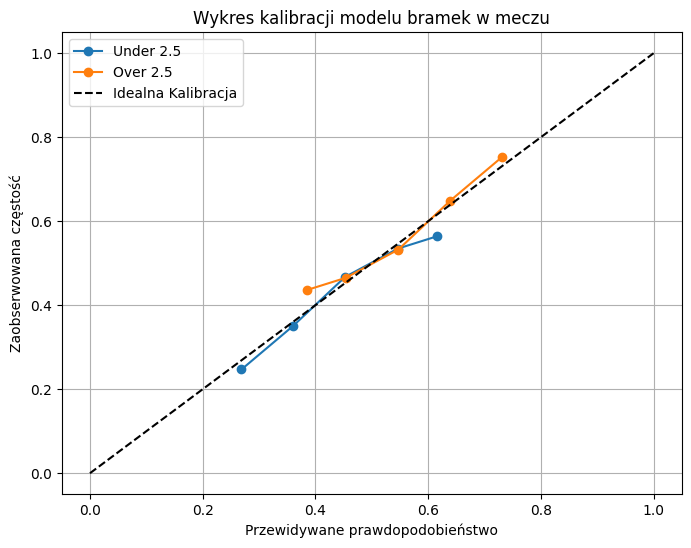

In [111]:
plt.figure(figsize=(8, 6))
plt.plot(calibration_under['avg_pred_prob'], calibration_under['observed_freq'], marker='o', label="Under 2.5")
plt.plot(calibration_over['avg_pred_prob'], calibration_over['observed_freq'], marker='o', label="Over 2.5")
plt.plot([0, 1], [0, 1], 'k--', label="Idealna Kalibracja")
plt.title("Wykres kalibracji modelu bramek w meczu")
plt.xlabel("Przewidywane prawdopodobieństwo")
plt.ylabel("Zaobserwowana częstość")
plt.legend()
plt.grid()
plt.show()

### Porównanie wyników z bukmacherami

In [100]:
odds_23_24 = pd.read_csv("data/E0_23-24.csv")
odds_22_23 = pd.read_csv("data/E0_22-23.csv")
odds_21_22 = pd.read_csv("data/E0_21-22.csv")
odds_20_21 = pd.read_csv("data/E0_20-21.csv")
odds_19_20 = pd.read_csv("data/E0_19-20.csv")
odds_18_19 = pd.read_csv("data/E0_18-19.csv")
odds_17_18 = pd.read_csv("data/E0_17-18.csv")
odds = pd.concat([odds_23_24, odds_22_23, odds_21_22, odds_20_21, odds_19_20, odds_18_19, odds_17_18], ignore_index=True)

In [101]:
all_teams = matches["home_team"].unique()
odds['HomeTeam'] = odds['HomeTeam'].apply(lambda x:process.extractOne(x, all_teams)[0])
odds['AwayTeam'] = odds['AwayTeam'].apply(lambda x:process.extractOne(x, all_teams)[0])

In [102]:
# subset_merged_df = merged_df[[col for col in merged_df.columns if 'last5' in col or 'outcome' in col ]]
key_columns = X_test.columns
filtered_matches = matches[matches[key_columns].isin(X_test[key_columns]).all(axis=1)]
filtered_matches["date"] = pd.to_datetime(filtered_matches['date'])
# matches["date"] = pd.to_datetime(matches['date'])

C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\1688989562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_matches["date"] = pd.to_datetime(filtered_matches['date'])


In [103]:
odds['Date'] = pd.to_datetime(odds['Date'], format='%d/%m/%Y')
odds = odds[["Date", "HomeTeam", "AwayTeam", "B365>2.5", "B365<2.5", "BbMx>2.5", "BbMx<2.5"]]
odds["B365<2.5"] = odds["B365<2.5"].fillna(odds["BbMx<2.5"])
odds["B365>2.5"] = odds["B365>2.5"].fillna(odds["BbMx>2.5"])
odds.rename(columns={
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team'
}, inplace=True)

In [104]:

merged_df = pd.merge(
    filtered_matches,
    odds,
    how='inner',
    left_on=['home_team', 'away_team', 'date'],
    right_on=['home_team', 'away_team', 'Date']
)
merged_df.drop(columns=['Date'], inplace=True)

In [105]:
merged_df["B365probs>2.5"] = 1 / merged_df["B365>2.5"] / (1 / merged_df["B365>2.5"] + 1 / merged_df["B365<2.5"])
merged_df["B365probs<2.5"] = 1 / merged_df["B365<2.5"] / (1 / merged_df["B365>2.5"] + 1 / merged_df["B365<2.5"])

In [106]:
bin_edges = np.arange(0, 1.1, 0.1)
df = pd.DataFrame({
    'over': merged_df["B365probs>2.5"],
    'under': merged_df["B365probs<2.5"],
    'actual': merged_df["over_2.5"]
})

bins = np.linspace(0, 1, 11)
df['bin_over'] = pd.cut(df['over'], bins=bins, labels=bins[:-1])
df['bin_under'] = pd.cut(df['under'], bins=bins, labels=bins[:-1])
calibration_over = df.groupby('bin_over', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['over'].mean(),
        'observed_freq': (x['actual'] == 1).mean(),
        'count': x['over'].count(),
        'difference' : - x['over'].mean() + (x['actual'] == 1).mean()
    })
).reset_index()
calibration_under = df.groupby('bin_under', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['under'].mean(),
        'observed_freq': (x['actual'] == 0).mean(),
        'count': x['under'].count(),
        'difference': - x['under'].mean() + (x['actual'] == 0).mean()
    })
).reset_index()

def mask_low_count(df, bin_col):
    for col in df.columns:
        if col != bin_col and col != 'count':
            df.loc[df['count'] < 10, col] = None
    return df

calibration_over["metric"] = abs(calibration_over["difference"]) * abs(calibration_over["difference"]) * calibration_over["count"] / len(df)
calibration_under["metric"] = abs(calibration_under["difference"]) * abs(calibration_under["difference"]) * calibration_under["count"] / len(df)

calibration_over = mask_low_count(calibration_over, 'bin_over')
calibration_under = mask_low_count(calibration_under, 'bin_under')

print("nasza metryka: " + str(calibration_over["metric"].sum() + calibration_under["metric"].sum()))
calibration_under

nasza metryka: 0.005495836641462504


C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\335197219.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_over = df.groupby('bin_over', observed=False, dropna=False).apply(
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_17308\335197219.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_under = df.groupby('bin_under', observed=False, dropna=False).apply(


,bin_under,avg_pred_prob,observed_freq,count,difference,metric
0,0.0,NaN,NaN,0.0,NaN,NaN
1,0.1,NaN,NaN,0.0,NaN,NaN
2,0.2,0.275065,0.250000,12.0,-0.025065,0.000013
3,0.3,0.364543,0.260000,100.0,-0.104543,0.001931
4,0.4,0.459320,0.443609,266.0,-0.015711,0.000116
5,0.5,0.546680,0.572327,159.0,0.025647,0.000185
6,0.6,0.624288,0.724138,29.0,0.099850,0.000511
7,0.7,NaN,NaN,0.0,NaN,NaN
8,0.8,NaN,NaN,0.0,NaN,NaN
9,0.9,NaN,NaN,0.0,NaN,NaN


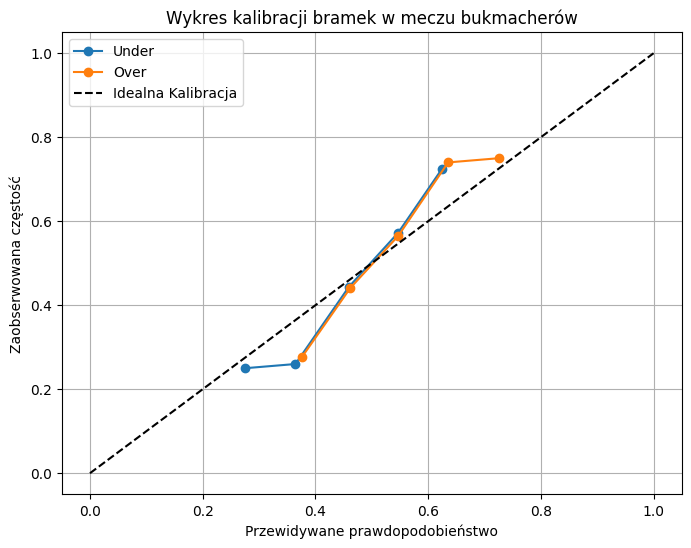

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(calibration_under['avg_pred_prob'], calibration_under['observed_freq'], marker='o', label="Under")
plt.plot(calibration_over['avg_pred_prob'], calibration_over['observed_freq'], marker='o', label="Over")
plt.plot([0, 1], [0, 1], 'k--', label="Idealna Kalibracja")
plt.title("Wykres kalibracji bramek w meczu bukmacherów")
plt.xlabel("Przewidywane prawdopodobieństwo")
plt.ylabel("Zaobserwowana częstość")
plt.legend()
plt.grid()
plt.show()

### Inne linie na podstawie rozkładu Poissona

In [479]:
import math
from scipy.optimize import minimize_scalar

def poisson_cdf(lmbda, k):
    return sum((lmbda ** i) * math.exp(-lmbda) / math.factorial(i) for i in range(k + 1))

def solve_lambda(p_over_2_5):
    def objective(lmbda):
        p_leq_2 = poisson_cdf(lmbda, 2)
        return abs(1 - p_leq_2 - p_over_2_5)

    result = minimize_scalar(objective, bounds=(0, 10), method='bounded')
    return result.x

def poisson_probability(lmbda, line, over=True):
    if over:
        return 1 - poisson_cdf(lmbda, math.floor(line))
    else:
        return poisson_cdf(lmbda, math.floor(line))

# Example usage
p_over_2_5 = 0.675862

# Step 1: Solve for lambda
lambda_estimate = solve_lambda(p_over_2_5)
print(f"Estimated lambda (expected goals): {lambda_estimate:.4f}")

# Step 2: Calculate probabilities for other lines
p_over_1_5 = poisson_probability(lambda_estimate, 1.5, over=True)
print(f"Probability of over 1.5 goals: {p_over_1_5:.4f}")

p_under_1_5 = poisson_probability(lambda_estimate, 1.5, over=False)
print(f"Probability of under 1.5 goals: {p_under_1_5:.4f}")

p_over_3_5 = poisson_probability(lambda_estimate, 3.5, over=True)
print(f"Probability of over 3.5 goals: {p_over_3_5:.4f}")

p_under_3_5 = poisson_probability(lambda_estimate, 3.5, over=False)
print(f"Probability of under 3.5 goals: {p_under_3_5:.4f}")


Estimated lambda (expected goals): 3.4823
Probability of over 1.5 goals: 0.8622
Probability of under 1.5 goals: 0.1378
Probability of over 3.5 goals: 0.4595
Probability of under 3.5 goals: 0.5405
